<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/temp/04.neural_networks/04.neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import random



!pip install category_encoders
import category_encoders as ce




# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

from functools import partial

--2021-05-03 20:23:53--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py.2’

visualization.py.2  100%[===================>]  12.70K  --.-KB/s    in 0s      

2021-05-03 20:23:53 (65.9 MB/s) - ‘visualization.py.2’ saved [13008/13008]



### Mount your Google Drive

Training a neural network may take long time and you don't want to do it every time. Once you've trained a model, it is better to save it, so that you can use it immediately for prediction next times.

Unfortunately, the storage on Google is reset every time. You need to store all persistent data in you Google Drive.

You need therefore to mount your Google Drive, which you will use later in this notebook

In [25]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/04.neural-networks/'

Mounted at /content/gdrive


# Use case description

The use case is from [ComCom19].


**Goal** Estimate bandwidth available between two communicating endpoints.
![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/train-of-packets.png)

**Why**: Knowing the available bandwidth, video streaming clients can properly choose the quality level to request.



Measures
* Bits per seconds sent $r_{\text{in}}$
* Bits per second received $r_\text{out}$



![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/r_in-r_out.png)
\[Figure from [ComCom19] \]


The auhtors set up the following testbed:


![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/testbed.png)


Measures are collected in the **Video Receiver**. All the other machines just produce cross-traffic.

Measures are recorded via an Endace Data Acquisition and Generation (DAG) card, which timestamp all packets in an extremely precise way.

![alt text](https://www.endace.com/assets/images/products/DAG%209.5G4F_angled_small.png)

([Producer website](https://www.endace.com/endace-high-speed-packet-capture-solutions/oem/dag/))



# Traces

The description of the dataset can be found in the Appendix of Khangura's [PhD thesis](https://www.repo.uni-hannover.de/bitstream/handle/123456789/9219/Khangura_Sukhpreet_PhD_Thesis.pdf?sequence=3&isAllowed=y).

In [26]:
!wget http://www-public.imtbs-tsp.eu/~araldo/pmwiki/uploads/datasets/BandwidthEstimationTraces.zip

--2021-05-03 19:54:55--  http://www-public.imtbs-tsp.eu/~araldo/pmwiki/uploads/datasets/BandwidthEstimationTraces.zip
Resolving www-public.imtbs-tsp.eu (www-public.imtbs-tsp.eu)... 157.159.10.118
Connecting to www-public.imtbs-tsp.eu (www-public.imtbs-tsp.eu)|157.159.10.118|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1119200 (1.1M) [application/zip]
Saving to: ‘BandwidthEstimationTraces.zip.1’

BandwidthEstimation 100%[===================>]   1.07M  1.72MB/s    in 0.6s    

2021-05-03 19:54:56 (1.72 MB/s) - ‘BandwidthEstimationTraces.zip.1’ saved [1119200/1119200]



In [27]:
! unzip -o -q BandwidthEstimationTraces.zip

In [28]:
!ls BandwidthEstimationTraces

testing  training


Training and test datasets are separated

In [29]:
! ls BandwidthEstimationTraces/training

MultiLinkCapacity100   TightLinkafterBottleneckLink
SingleLinkCapacity100  TightLinkbeforeBottleneckLink
SingleLinkCapacity50


For simplicity, we will just consider the case with a single link between client and server.

In [30]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100

25_et_100_C_5_delta  50_et_100_C_5_delta  75_et_100_C_5_delta


There are three sets of traces:
* With cross traffic rate $\lambda$=25 Mbps
* With cross traffic rate $\lambda$=50 Mbps
* With cross traffic rate $\lambda$=75 Mbps

All rates are intended at the Ethernet level

In [31]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta

75_et_100_C_5_delta_100.csv  75_et_100_C_5_delta_55.csv
75_et_100_C_5_delta_10.csv   75_et_100_C_5_delta_56.csv
75_et_100_C_5_delta_11.csv   75_et_100_C_5_delta_57.csv
75_et_100_C_5_delta_12.csv   75_et_100_C_5_delta_58.csv
75_et_100_C_5_delta_13.csv   75_et_100_C_5_delta_59.csv
75_et_100_C_5_delta_14.csv   75_et_100_C_5_delta_5.csv
75_et_100_C_5_delta_15.csv   75_et_100_C_5_delta_60.csv
75_et_100_C_5_delta_16.csv   75_et_100_C_5_delta_61.csv
75_et_100_C_5_delta_17.csv   75_et_100_C_5_delta_62.csv
75_et_100_C_5_delta_18.csv   75_et_100_C_5_delta_63.csv
75_et_100_C_5_delta_19.csv   75_et_100_C_5_delta_64.csv
75_et_100_C_5_delta_1.csv    75_et_100_C_5_delta_65.csv
75_et_100_C_5_delta_20.csv   75_et_100_C_5_delta_66.csv
75_et_100_C_5_delta_21.csv   75_et_100_C_5_delta_67.csv
75_et_100_C_5_delta_22.csv   75_et_100_C_5_delta_68.csv
75_et_100_C_5_delta_23.csv   75_et_100_C_5_delta_69.csv
75_et_100_C_5_delta_24.csv   75_et_100_C_5_delta_6.csv
75_et_100_C_5_delta_25.csv   75_et_100_C_5_delta_7

Every experiment is repeated 100 times.

Let's check the trace of one experiment

In [32]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df

,100,25
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280
5,1.10830,29.9820
6,1.27700,35.3180
7,1.27810,39.9750
8,1.24280,44.5390
9,1.42630,50.0520


The header is not a sample. It just tells us the scenario, i.e. total channel capacity (Mbps) and available bandwith (Mbps).

The columns are:
* 1st column: ratio $r_\text{in} / r_\text{out}$
* 2nd column: Some sort of time stamp that we will ignore (not well described in the dataset)



![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/r_in-r_out.png)
\[Figure from [ComCom19] \]


Let's rename the columns to avoid ambiguity

In [33]:
df.columns=['ratio', 'timestamp']
df.head()

,ratio,timestamp
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280


# Feature engineering

Each experiment will be a sample.

The features of a sample are the elements of the histogram of the first column

(array([2.46797799, 1.23398899, 0.6169945 , 1.23398899, 1.23398899,
        1.23398899, 1.23398899, 0.6169945 , 0.6169945 , 1.85098349]),
 array([0.99982 , 1.080858, 1.161896, 1.242934, 1.323972, 1.40501 ,
        1.486048, 1.567086, 1.648124, 1.729162, 1.8102  ]),
 <a list of 10 Patch objects>)

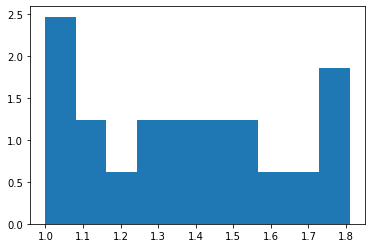

In [34]:
plt.hist(df['ratio'], density=True)

# density:  True garantees that the area is 1 (such that the histogram 
#     approximates a probability density function)

The histogram above is just our sample, describing an experiment, which is a sequence of measures. In this case, the histogram above is telling us that most of the time a ratio between 1.00 and 1.05 has been measured; also values of ratio between 1.75 and 1.80 have been measured many times.

However, the sequence of bins is chosen automatically by `matplotlib` and may change from an experiment to another.

We need instead to describe all the experiments with a uniform set of features => The sequence of bins must be the same for all the experiments.

To do so:
* Open all files
* Take the min and max ratio from all the experiments
* Divide the [min,max] interval uniformly

In [35]:
def get_all_csv_files(folder):
  """
  Credits to https://perials.com/getting-csv-files-directory-subdirectories-using-python/

  Returns all the csv files within the folder, and all subfolders
  """
  import os
  from glob import glob
  PATH = "/home/someuser/projects/someproject"
  EXT = "*.csv"
  all_csv_files = [file
                  for path, subdir, files in os.walk(folder)
                  for file in glob(os.path.join(path, "*.csv"))]
  return all_csv_files

To avoid data leaks, we compute the max and the min on the training set only.

In [36]:
train_files = get_all_csv_files('BandwidthEstimationTraces/training')
print('Found ', len(train_files), ' training files' )

Found  1100  training files


Find the min and max

In [37]:
min_ratio = float('inf')
max_ratio = 0

for filename in train_files:
      df = pd.read_csv(filename)
      df.columns=['ratio', 'timestamp']
      trace_min = min( df['ratio'] )
      trace_max = max( df['ratio'] )
      min_ratio = min ( [ min_ratio, trace_min ] )
      max_ratio = max ( [ max_ratio, trace_max ] )

print('min_ratio:', min_ratio, ' max_ratio:',max_ratio)

min_ratio: 0.95975  max_ratio: 2.318


Let's create the bins that we will use for all experiments

In [38]:
N = 8 # num of bins

bin_size = (max_ratio-min_ratio)/N 
bins = [min_ratio + i * bin_size for i in range(0, N+1)]
bins

[0.95975,
 1.1295312499999999,
 1.2993125,
 1.4690937499999999,
 1.638875,
 1.8086562499999999,
 1.9784375,
 2.14821875,
 2.318]

Just as a visual check, let's plot again the previous histogram with these new bins

[1.76697957 0.88348978 1.17798638 0.88348978 0.88348978 0.29449659
 0.         0.        ]


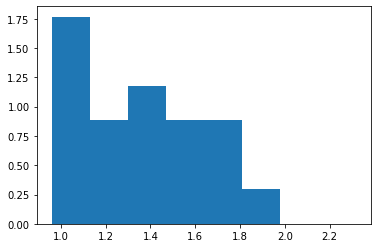

In [39]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df.columns=['ratio', 'timestamp']
hist_values, bins, bars = plt.hist( df['ratio'], density=True, bins=bins)
print(hist_values )

As specified previously, this histogram is a sample for us. In particular, this sample is the vector 

  `[1.77 0.89 1.18 0.89 0.89 0.29 0 0]`

Let's obtain the histogram for all the experiments. For each experiment, the corresponding sample is a vector in the following form:

  `[bin1_freq, bin2_freq, ...., binN_freq]`

and a label `avail_bandwidth`.

We write these operations in a function `construct_dataset` that we will then use for the training and the test dataset.

This is to avoid **copied and pasted code**, which is prone to error.

In [40]:
def process_file(filename, bins):
      """
      For the connection described in filename, it
      returns a feature vector and the available bandwidth
      """
      df = pd.read_csv(filename)

      # Observe that for each experiment, the available bandwidth corresponds 
      # to the name of the second column
      avail_band = df.columns[1]


      df.columns=['ratio', 'timestamp']

      histogram_values, bins, bars = plt.hist( df['ratio'], density=True, 
                                              bins=bins)

      return histogram_values, avail_band



def construct_dataset(files, bins):
  """
  Build an X,y from the files
  """

  X = np.empty((0,N), int)
  label = []

  for filename in files:
      histogram_values, avail_band = process_file(filename, bins)

      X = np.vstack(( X, histogram_values) )
      label.append(avail_band)

  return X,label

Found  1000  test files


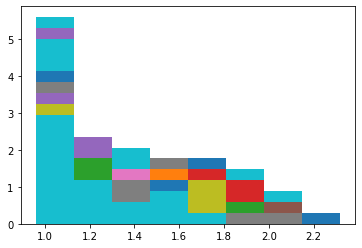

In [41]:
X_train_raw, label_train_raw = construct_dataset(train_files, bins)

test_files = get_all_csv_files('BandwidthEstimationTraces/testing')
print ('Found ', len(test_files), ' test files'  )

X_test, label_test = construct_dataset(test_files, bins)

In [42]:
print('X_train\n', X_train_raw[0:6, :] )
print('\n\nlabel_train\n',label_train_raw )

X_train
 [[4.71194552 1.17798638 0.         0.         0.         0.
  0.         0.        ]
 [5.00644211 0.58899319 0.29449659 0.         0.         0.
  0.         0.        ]
 [4.71194552 0.88348978 0.29449659 0.         0.         0.
  0.         0.        ]
 [4.41744892 1.17798638 0.29449659 0.         0.         0.
  0.         0.        ]
 [5.00644211 0.58899319 0.29449659 0.         0.         0.
  0.         0.        ]
 [4.12295233 1.47248297 0.29449659 0.         0.         0.
  0.         0.        ]]


label_train
 ['50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '50', '5

In [43]:
sample_size = X_train_raw.shape[1]
print('The sample size is ', sample_size, 
      ', which should correspond to the number of bins ', N)

The sample size is  8 , which should correspond to the number of bins  8


### Class imbalance

Let's check for class imbalance

In [44]:
Counter(label_train_raw)

Counter({'12.5': 100, '25': 400, '37.5': 100, '50': 400, '75': 100})

Correct using Synthetic Minority Over-Sampling Technique (SMOTE) (see `03.classification.ipynb`)

In [45]:
smote = SMOTE()
X_train, label_train = smote.fit_sample(X_train_raw, label_train_raw)

Counter(label_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({'12.5': 400, '25': 400, '37.5': 400, '50': 400, '75': 400})

### Scaling
With NN is important to **scale** the dataset

In [46]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('X_train scaled\n', X_train[0:6, :] )

X_train scaled
 [[0.86666667 0.5        0.         0.         0.         0.
  0.         0.        ]
 [0.93333333 0.25       0.14285714 0.         0.         0.
  0.         0.        ]
 [0.86666667 0.375      0.14285714 0.         0.         0.
  0.         0.        ]
 [0.8        0.5        0.14285714 0.         0.         0.
  0.         0.        ]
 [0.93333333 0.25       0.14285714 0.         0.         0.
  0.         0.        ]
 [0.73333333 0.625      0.14285714 0.         0.         0.
  0.         0.        ]]


### One-hot encoding
**One-hot encode** the target

In [47]:
# OneHotEncoder works best with dataframes. Let's convert our y lists to 
# dataframes
label_train_df = pd.DataFrame({'label':label_train})
label_test_df = pd.DataFrame({'label':label_test})

label_train_df

,label
0,50
1,50
2,50
3,50
4,50
...,...
1995,75
1996,75
1997,75
1998,75


In [48]:
one_hot_encoder = ce.OneHotEncoder(cols=['label'], use_cat_names='True')
one_hot_encoder.fit(label_train_df)
y_train = one_hot_encoder.transform(label_train_df)
y_test  = one_hot_encoder.transform(label_test_df)

print('y_train', y_train)

num_of_classes = y_train.shape[1]
class_names =list(y_train.columns)
print('There are ', num_of_classes, ' classes. Their names is:', class_names)

y_train       label_50  label_75  label_25  label_37.5  label_12.5
0            1         0         0           0           0
1            1         0         0           0           0
2            1         0         0           0           0
3            1         0         0           0           0
4            1         0         0           0           0
...        ...       ...       ...         ...         ...
1995         0         1         0           0           0
1996         0         1         0           0           0
1997         0         1         0           0           0
1998         0         1         0           0           0
1999         0         1         0           0           0

[2000 rows x 5 columns]
There are  5  classes. Their names is: ['label_50', 'label_75', 'label_25', 'label_37.5', 'label_12.5']


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


# Build a NN model

To train faster, change the runtime to GPU or TPU.
In the Google Colab menu at the top, do `Runtime > Change Runtime Type` and select GPU or TPU (sometimes GPU is faster than TPU, sometimes it is the opposite; so you can infidderently try either of them).

The following function creates a neural network architecture and compiles it

In [68]:
def make_sequential_model(sample_size, layer_sizes, 
                          hidden_activation_function="relu", 
                          out_activation_function="softmax",
                          loss_fun="categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of 
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0], 
                  input_dim = sample_size) )
  
  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )
    
  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )
  

  model.compile(loss=loss_fun, 
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)
  
  return model

See Ch.10 of [Ge19] to know more about these hyper-parameters.

Loss function:
* `categorical_crossentropy` is the cross-entropy as we defined in the slides
* In binary classification then use `sigmoid` activation function in the output layer instead of the `softmax` and `binary_crossentropy` loss.

Optimizer:
* We are using Stochastic Gradient Descent with learning rate $\eta=$ `learn_rate`

Metrics:
* We are asking Keras to show at each epoch the accuracy. Note that the accuracy value is ignored during training. This metric is just visualized

As en example, let us instantiate our first neural network

In [ ]:
model = make_sequential_model(sample_size, [200, 50 ,30, 15,8, num_of_classes], 
                              learning_rate=0.1)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               1800      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 45        
Total params: 14,018
Trainable params: 14,018
Non-trainable params: 0
____________________________________________________

Let's introduce some operations to make our code **repeatable**: we want to have the same results, every time we run the different neural networks below, no matter the order in which we run them and no matter who runs them.

 To this aim, we use the following tricks:
 * `clear_session()`: it resets the neural network weights. If we do not do so, if we train a certain neural network A and then another neural network B, which may have the same architecture, some of the weights of B are initialized as in A. If we run in the opposite order, some of the weights of A are initialized as in B. Therefore, our results would depend on the order of training, which we do not want. This is why we will use `clear_session`. Actually, this function does even more: it resets all the variables handled by tensorflow. If you do not use it, every time you create a new neural network tensor flow will not remove the previous ones and adds the new one to its set of variables. This can bring to an excessive memory consumption. `clear_session` resets everything, thus solving memory problems.
 * Setting seeds: during training, there is some stochastic operations done: for instance, the validation set is chosen randomly, by default, the batch of samples is selected randomly at each iteration, etc.

In [74]:
def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))

This network is probably too big with respect to the small amount of data. However, nobody can tell us, until we see the training results.

**Always experiment with NNs of different sizes**

# Training

In [75]:
def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000, 
                overwrite=True, validation_split=0.2, patience=20):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training 
            (thanks to the ModelCheckpoint callback (see the implementation 
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.
  
  overwrite: boolean
            If true, the model will be built and trained from scratch, 
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the 
            specified number of epochs
  """
  
  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor 
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the 
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of 
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True) 


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb], 
                      validation_split=validation_split )

  return model

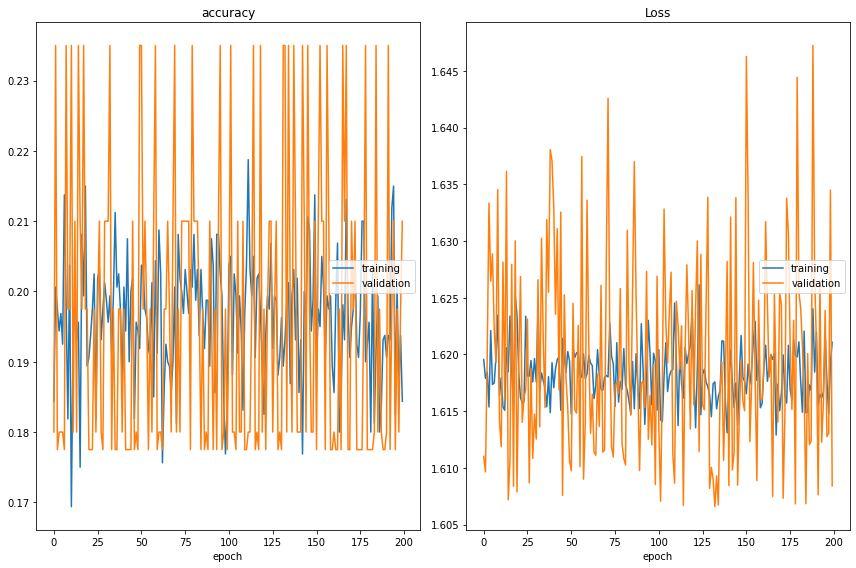

accuracy
	training         	 (min:    0.169, max:    0.219, cur:    0.184)
	validation       	 (min:    0.177, max:    0.235, cur:    0.210)
Loss
	training         	 (min:    1.613, max:    1.626, cur:    1.621)
	validation       	 (min:    1.607, max:    1.647, cur:    1.608)


In [ ]:
nn_file = my_path + 'nn-0.1.h5'

history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

Our NN does has not managed to converge yet. This is often due to the **learning rate being too large**. In our case, it was 0.1. Let's try a smaller one.

In [ ]:
model = make_sequential_model(sample_size, [200, 50 ,30, 15,8, num_of_classes], 
                              learning_rate=0.001)

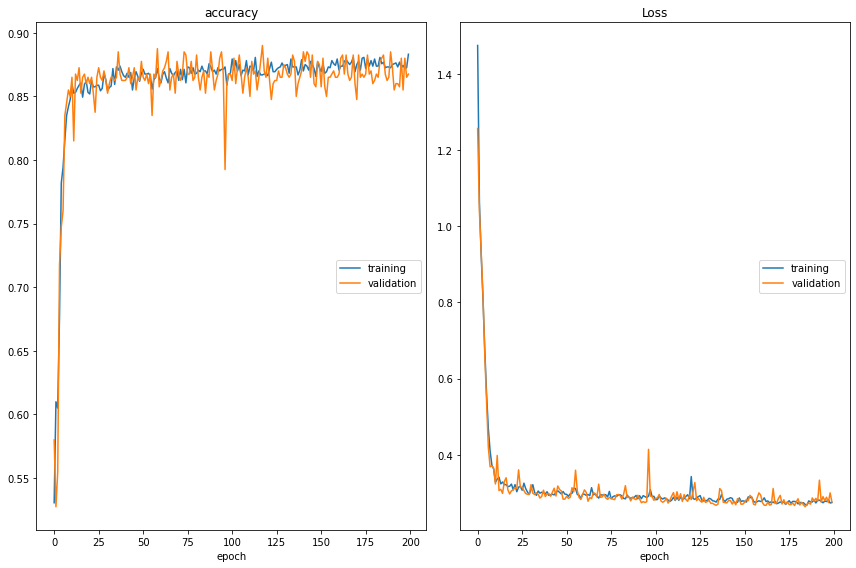

accuracy
	training         	 (min:    0.531, max:    0.883, cur:    0.883)
	validation       	 (min:    0.527, max:    0.890, cur:    0.868)
Loss
	training         	 (min:    0.268, max:    1.474, cur:    0.274)
	validation       	 (min:    0.263, max:    1.256, cur:    0.276)


In [ ]:
nn_file = my_path + 'nn-0.001.h5'

history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

Much better now. Let's try with a much smaller one.

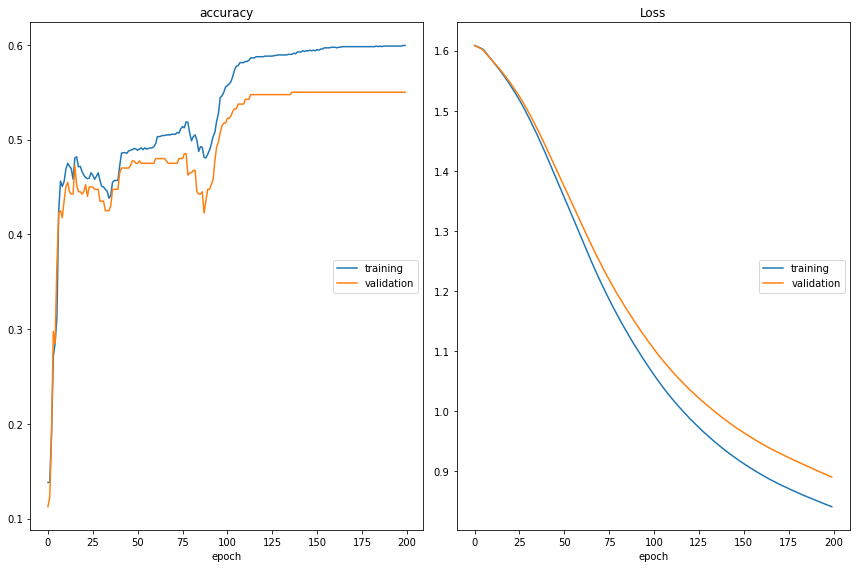

accuracy
	training         	 (min:    0.138, max:    0.599, cur:    0.599)
	validation       	 (min:    0.112, max:    0.550, cur:    0.550)
Loss
	training         	 (min:    0.841, max:    1.609, cur:    0.841)
	validation       	 (min:    0.891, max:    1.608, cur:    0.891)


In [ ]:
nn_file = my_path + 'nn-0.00001.h5'
model = make_sequential_model(sample_size, [200, 50 ,30, 15,8, num_of_classes], 
                              learning_rate=0.00001)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

Too slow. Let's try a learning rate in the middle

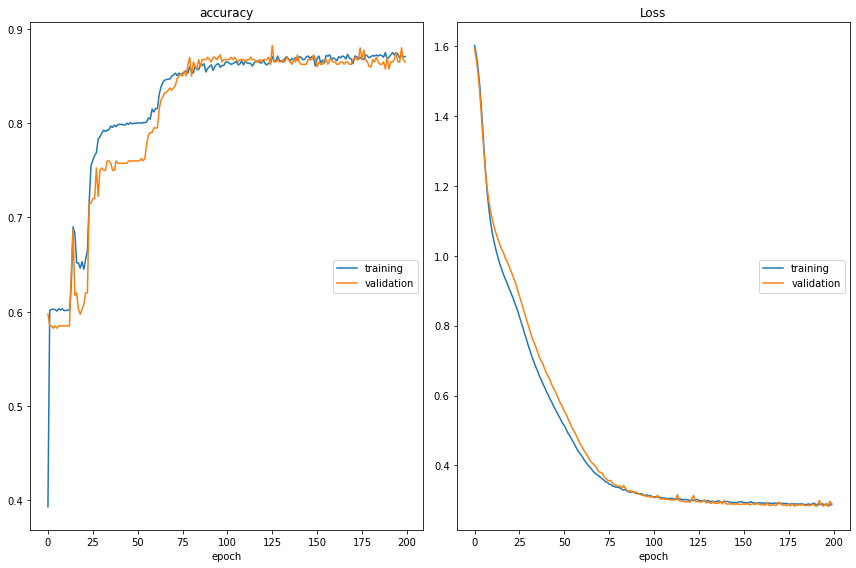

accuracy
	training         	 (min:    0.393, max:    0.875, cur:    0.871)
	validation       	 (min:    0.582, max:    0.882, cur:    0.865)
Loss
	training         	 (min:    0.286, max:    1.602, cur:    0.290)
	validation       	 (min:    0.282, max:    1.592, cur:    0.287)


In [ ]:
nn_file = my_path + 'nn-0.0001.h5'
model = make_sequential_model(sample_size, [200, 50 ,30, 15,8, num_of_classes], 
                              learning_rate=0.0001)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

Let's try with 0.01

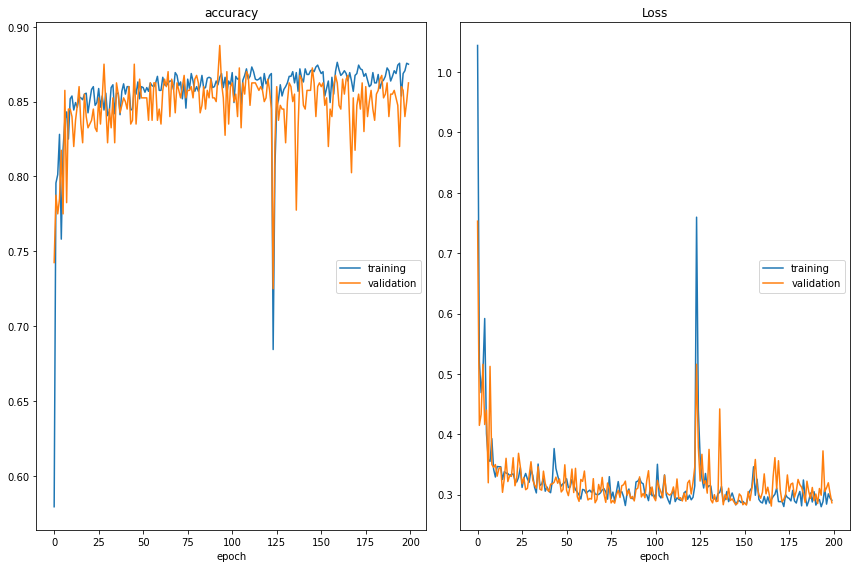

accuracy
	training         	 (min:    0.579, max:    0.876, cur:    0.875)
	validation       	 (min:    0.725, max:    0.887, cur:    0.863)
Loss
	training         	 (min:    0.280, max:    1.044, cur:    0.291)
	validation       	 (min:    0.281, max:    0.753, cur:    0.286)


In [ ]:
nn_file = my_path + 'nn-0.01.h5'
model = make_sequential_model(sample_size, [200, 50 ,30, 15,8, num_of_classes], 
                              learning_rate=0.01)
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=200)

## Recover the best model

Observing the validation loss curves, it seems that learning rate 0.001 is the best.

Let us thus recover the model with 0.001. Remember that our code saves automatically all the models. Therefore, we can load the already trained model from the respective file.

We also do some additional 300 epochs of training. Note that we do not start training from scratch, since the initial NN weights are the ones that we had at the end of the previous training, just before saving the model in the file. You have thus understood that saving models in files is a good practice, because we can also improve such models over and over again, even several days after our last training.

To load a previously existing model, we specify `overwrite=False`.

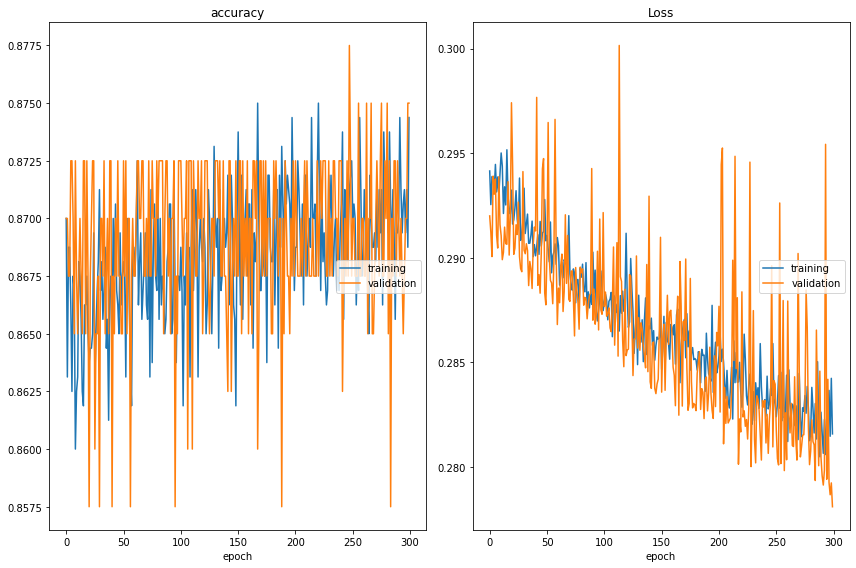

accuracy
	training         	 (min:    0.860, max:    0.875, cur:    0.874)
	validation       	 (min:    0.858, max:    0.877, cur:    0.875)
Loss
	training         	 (min:    0.280, max:    0.295, cur:    0.282)
	validation       	 (min:    0.278, max:    0.300, cur:    0.278)


In [ ]:
nn_file = my_path + 'nn-0.001.h5'
model = make_sequential_model(sample_size, [200, 50 ,30, 15,8, num_of_classes], 
                              learning_rate=0.0001, )
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=300,
                      overwrite=False)

Don't be mislead by the zoom! The model seems visually more "instable" than when we have saved it, but it is not. If you look at the y-axis, you can notice they are zoomed in a very small interval. So, oscillations seem big, but they are actually very small.

# Prediction

Let's use the model for prediction. 

In [51]:
nn_file = my_path + 'nn-0.001.h5'
model = load_model(nn_file)

Get the probability for each sample of being in a class.

In [52]:
y_proba = model.predict(X_test)
print( 'y_proba\n', y_proba)

y_proba
 [[8.4310549e-01 9.0660945e-10 1.4697996e-01 9.9144857e-03 1.8452399e-10]
 [8.5227734e-01 2.0665038e-07 1.5725624e-02 1.3199678e-01 1.4608462e-10]
 [6.1672968e-01 5.5399448e-07 3.6869533e-03 3.7958273e-01 1.5397459e-11]
 ...
 [4.7030121e-06 3.0857885e-15 9.9999511e-01 6.7350276e-13 2.3060809e-07]
 [1.5864709e-04 1.0032120e-13 9.9984121e-01 6.3011027e-11 1.4625482e-07]
 [9.2137447e-03 5.8147260e-14 9.9078631e-01 4.4514614e-08 2.0927127e-10]]


The predicted class of each sample is the one with the highest probability.

In [53]:
pred_label = model.predict_classes(X_test)
print( 'pred_label\n', pred_label )

pred_label
 [0 0 0 0 3 3 3 3 0 0 0 0 3 0 0 0 3 0 0 0 0 3 0 0 3 0 0 0 0 0 0 0 0 3 0 0 3
 0 3 0 0 0 0 0 3 0 3 0 0 0 0 0 0 0 3 3 0 0 3 3 0 0 3 3 0 0 3 0 0 0 3 0 0 3
 0 3 0 3 0 0 0 0 0 3 3 0 0 0 0 0 3 0 3 0 0 0 0 3 0 0 0 1 1 1 1 1 0 1 0 1 1
 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0
 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1
 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 3 0 0 1 1 1 0 0 0 1 0
 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 3 1 0 0 0 0 3 1 0 1 1 0 1 1 0 0 1 1 0 0 1
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


The best way to evaluate the model is the confusion matrix

In [54]:
y_test.values

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]])

We need to convert one-hot-encoded values to numerical labels

In [55]:
true_label = np.argmax(y_test.values, axis=1)
true_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Normalized confusion matrix
[[0.605      0.19833333 0.13666667 0.06      ]
 [0.08       0.92       0.         0.        ]
 [0.12333333 0.         0.87666667 0.        ]
 [       nan        nan        nan        nan]]


/content/visualization.py:123: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


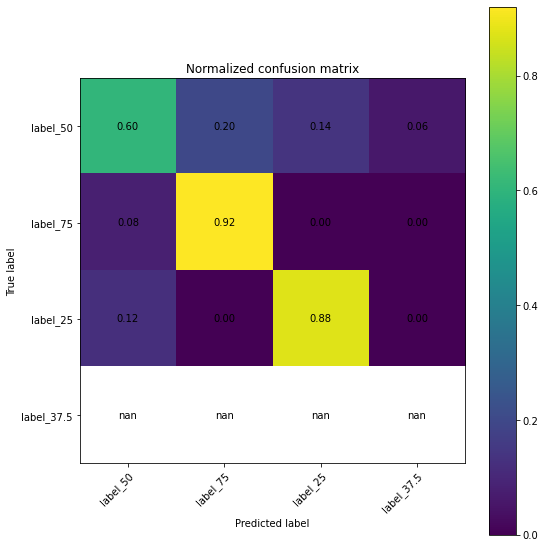

In [59]:
plot_conf_mat(true_label, pred_label, np.array(class_names) )

In [61]:
print("The names of the classes are ", class_names)
print("The true classes found in the test set are ", Counter(true_label) )
print("The predicted classes are ", Counter(pred_label) )

The names of the classes are  ['label_50', 'label_75', 'label_25', 'label_37.5', 'label_12.5']
The true classes found in the test set are  Counter({0: 600, 2: 300, 1: 100})
The predicted classes are  Counter({0: 408, 2: 345, 1: 211, 3: 36})


Observe that class `3`, i.e., `label_37.5` is predicted by the model but does not appear in the test set. This is why it appear as `nan` in the confusion matrix.

Observe also that class `4`, i.e., `label_12.5` does not appear neither in the true labels of the test set, nor in the predicted labels. For this reason it does not appear in the confusion matrix.

In [62]:
print( classification_report(true_label, pred_label, labels=[0,1,2,3,4],
                             target_names=class_names) )

              precision    recall  f1-score   support

    label_50       0.89      0.60      0.72       600
    label_75       0.44      0.92      0.59       100
    label_25       0.76      0.88      0.82       300
  label_37.5       0.00      0.00      0.00         0
  label_12.5       0.00      0.00      0.00         0

   micro avg       0.72      0.72      0.72      1000
   macro avg       0.42      0.48      0.43      1000
weighted avg       0.81      0.72      0.74      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Smaller architecture

Let us now try a smaller neural network and check if it is better.

In [77]:
model = make_sequential_model(sample_size, [8, 6, num_of_classes], 
                              learning_rate=0.01)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 54        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 35        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


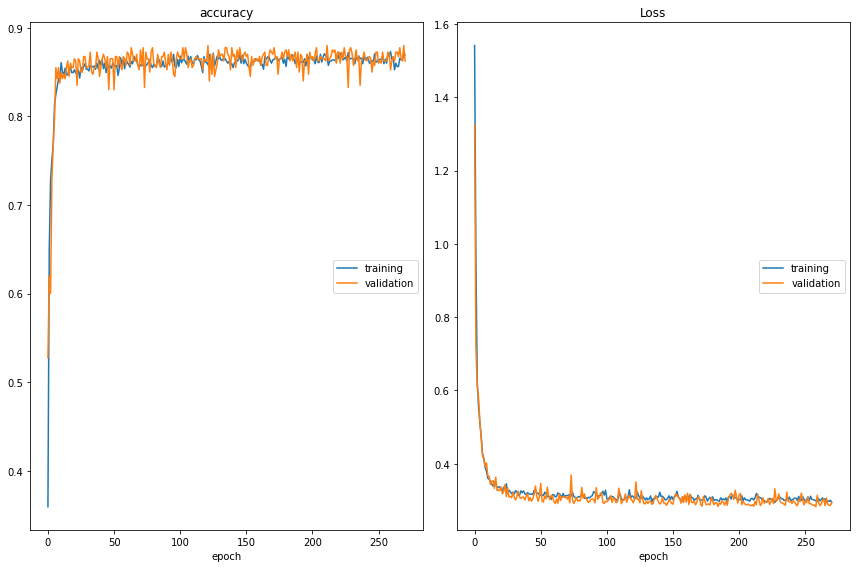

accuracy
	training         	 (min:    0.359, max:    0.873, cur:    0.869)
	validation       	 (min:    0.527, max:    0.880, cur:    0.863)
Loss
	training         	 (min:    0.294, max:    1.541, cur:    0.294)
	validation       	 (min:    0.283, max:    1.326, cur:    0.295)
Epoch 272/300
50/50 [==============================] - 0s 2ms/step - loss: 0.2944 - accuracy: 0.8713 - val_loss: 0.2872 - val_accuracy: 0.8775


In [ ]:
nn_file = my_path + 'nn-small-lr_0.01.h5'
history = train_model(model, nn_file, X_train, y_train, seed=5, max_epochs=300)

We still need to improve. You can play with hyper-parameters (see slides):
* Try simpler architectures
* Try more complex architectures
* Regularize (use the parameter `regularization_coeff` of the function `make_sequential` defined in this noteboook)
* Change the optimizer
* Change the activation functions
* Change the batch size (default in `model.fit(..)` is 32)

# Limits of the work

* Only a finite set of available bandwidth values are used (12.5, 25, 37.5, 50, 75 Mbps). In reality, any value can occur => Need to extend the test and validation test with random bandwidth values.
* Is the method precise also when the total capacity is not 100 Mbps?

# Regression
We have so far only used neural network to perform classification. It is also possible to perform regression. To do so, the code remains essentially the same, just change the last layer: instead of `softmax`, put `Dense(1)` (see pagg. 307-308 of [Ge19]).



# References

* [ComCom19] Khangura, S. K., Fidler, M., & Rosenhahn, B. (2019). Machine learning for measurement-based bandwidth estimation. Computer Communications, 144(1), 18–30.
* [Ge19] Geron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2019, O'Reilly
* [KhConf19] Khangura, S. K. (2019). Neural Network-based Available Bandwidth Estimation from TCP Sender-side Measurements. In IEEE/IFIP PEMWN.
* [KhThesis19] Khangura, S. K. (2019). Machine Learning-based Available Bandwidth Estimation. Leibniz University.